In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#import zipfile
#zip_ref = zipfile.ZipFile("/content/drive/MyDrive/brain-mri-dataset.zip", 'r')
#zip_ref.extractall("/content/dataset")
#zip_ref.close()

In [3]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization, InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

2024-11-05 21:46:10.009925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730839570.021117    2532 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730839570.024631    2532 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 21:46:10.035800: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
train_path = './content/dataset/Training'

filepaths = []
labels = []

directories = os.listdir(train_path)
for directory in directories:
    f_path = os.path.join(train_path, directory)
    filelists = os.listdir(f_path)
    filepaths.extend([os.path.join(f_path, file) for file in filelists])
    labels.extend([directory] * len(filelists))

train_frame = pd.DataFrame({'filepaths': filepaths, 'label': labels})

print(train_frame.shape)

(5712, 2)


In [5]:
test_path = './content/dataset/Testing'

filepaths = []
labels = []

directories = os.listdir(test_path)
for directory in directories:
    f_path = os.path.join(test_path, directory)
    filelists = os.listdir(f_path)
    filepaths.extend([os.path.join(f_path, file) for file in filelists])
    labels.extend([directory] * len(filelists))

test_frame = pd.DataFrame({'filepaths': filepaths, 'label': labels})

print(test_frame.shape)

(1311, 2)


In [6]:
train, valid = train_test_split(train_frame, train_size=0.9, shuffle=True, random_state=42)

print(train.shape)
print(valid.shape)


(5140, 2)
(572, 2)


In [7]:
img_size = (300, 300)
batch_size = 16
tr_gen = ImageDataGenerator(
                            rotation_range=5,
                            width_shift_range=0.02,
                            height_shift_range=0.02,
                            horizontal_flip=True)

ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train, x_col = 'filepaths', y_col = 'label', target_size = img_size,
                                      class_mode = 'categorical', color_mode = 'rgb', shuffle = True , batch_size = batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid, x_col = 'filepaths', y_col = 'label', target_size = img_size,
                                       class_mode = 'categorical', color_mode = 'rgb', shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test_frame, x_col= 'filepaths', y_col = 'label', target_size = img_size,
                                      class_mode = 'categorical', color_mode= 'rgb', shuffle = False, batch_size = batch_size)

Found 5140 validated image filenames belonging to 4 classes.
Found 572 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


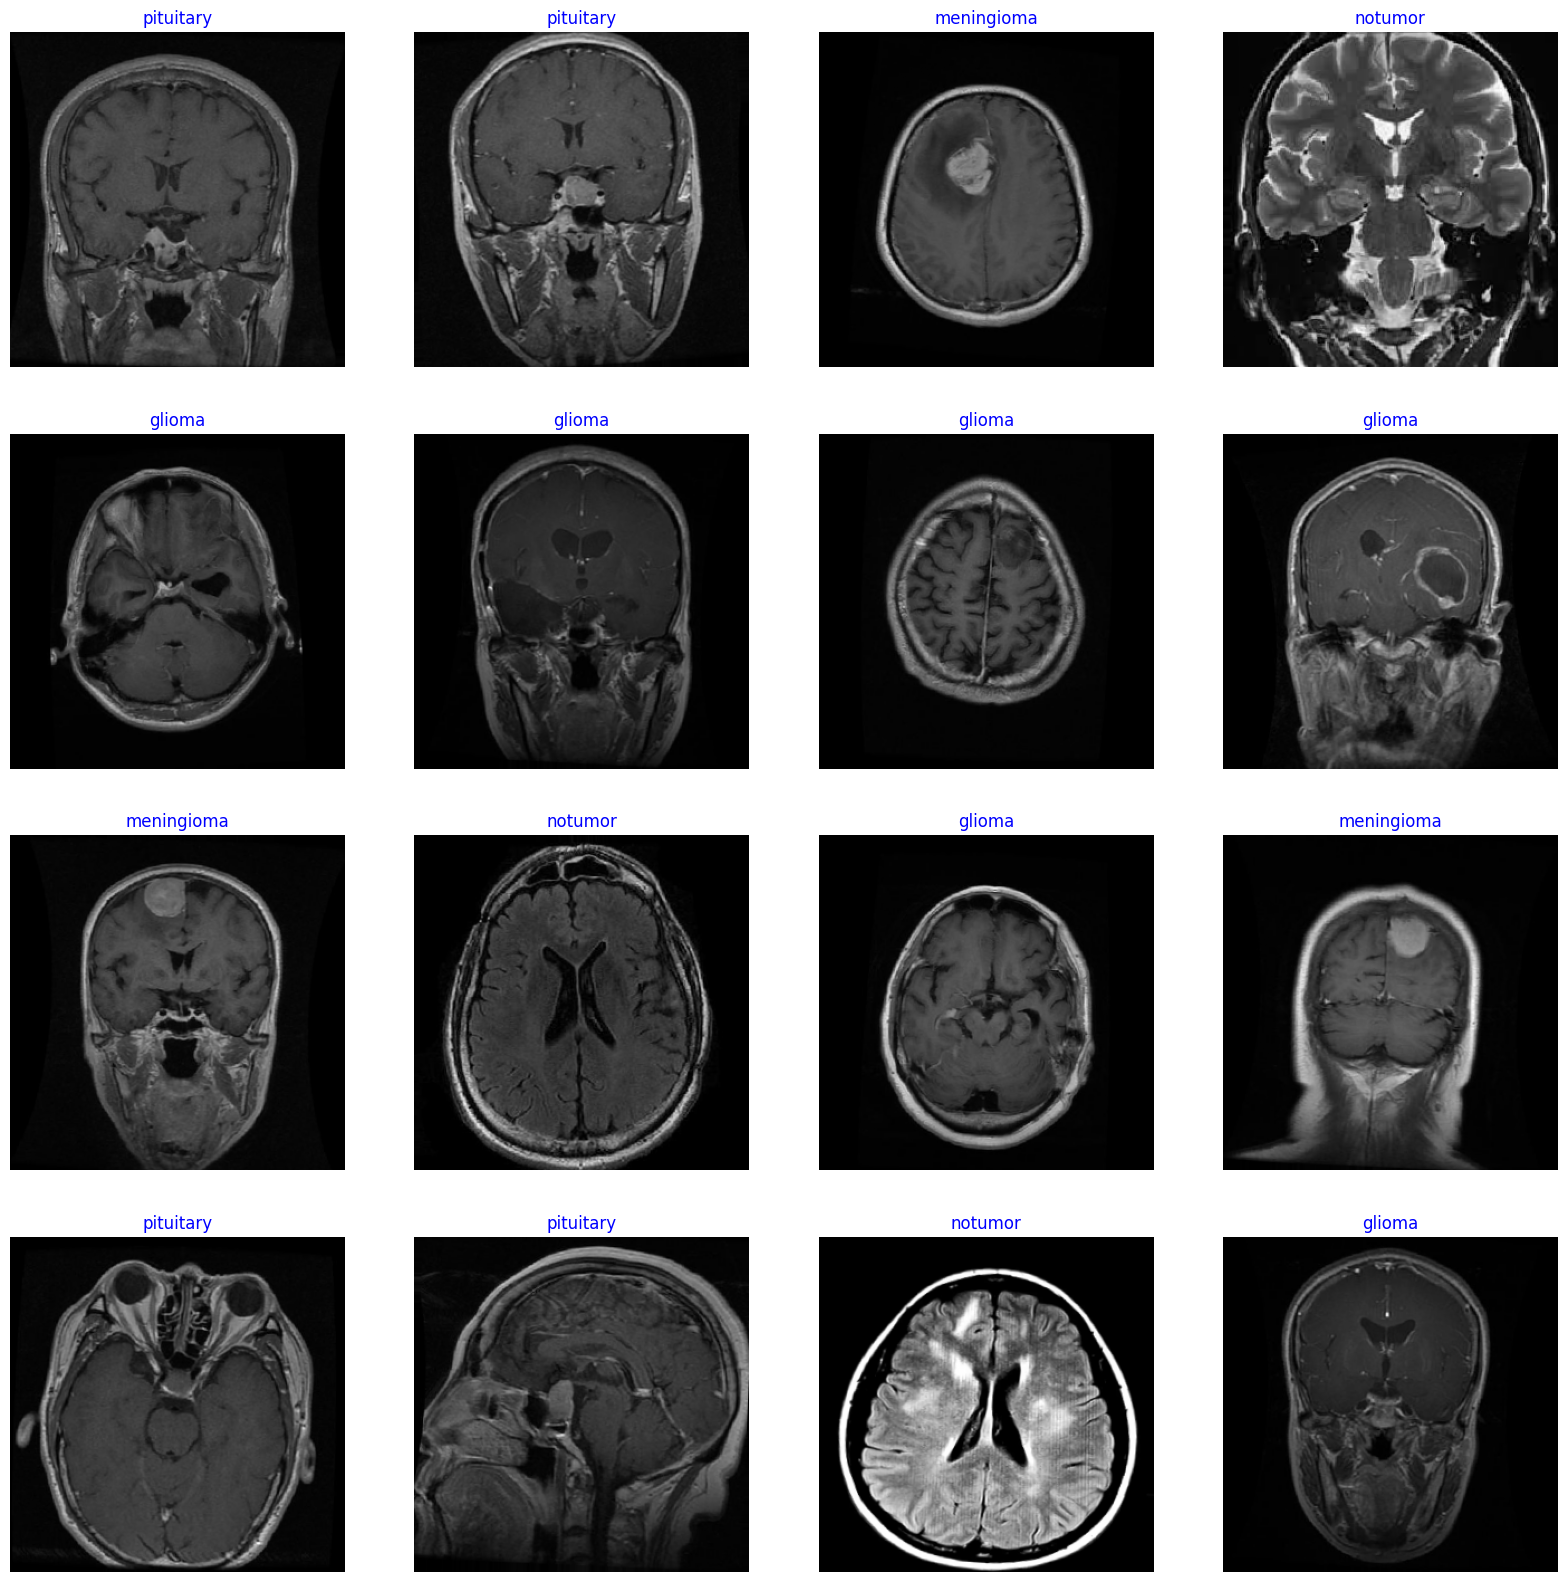

In [8]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    if i < len(images):
        image = images[i] / 255
        ax.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        ax.set_title(class_name, color='blue', fontsize=12)
        ax.axis('off')
    else:
        break

plt.show()

In [9]:

img_shape = (300, 300, 3)

base_model = tf.keras.applications.EfficientNetB5(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    pooling='max'
)

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256,
          kernel_regularizer=regularizers.l2(0.015),
          activity_regularizer=regularizers.l1(0.005),
          bias_regularizer=regularizers.l1(0.005),
          activation='relu'),
    Dropout(rate=0.35, seed=42),
    Dense(4, activation='softmax')
])

model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.build(input_shape=(None, 300, 300, 3))
model.summary()

I0000 00:00:1730839572.295510    2532 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4699 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1


115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb5 (Functional)     │ (None, 2048)           │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,047,291 (110.81 MB)

 Trainable params: 28,870,452 (110.13 MB)

 Non-trainable params: 176,839 (690.78 KB)

In [10]:
Epochs = 12

history = model.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen,
                   validation_steps=None, shuffle=False)

/home/mia/.tf_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12


I0000 00:00:1730839637.686110    2617 service.cc:148] XLA service 0x7fdb8c002c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730839637.686141    2617 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-11-05 21:47:19.792354: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730839643.759469    2617 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1730839703.274648    2617 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


321/322 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.6767 - loss: 10.0712

2024-11-05 21:53:03.915285: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_20', 16 bytes spill stores, 28 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_36', 16 bytes spill stores, 28 bytes spill loads



322/322 ━━━━━━━━━━━━━━━━━━━━ 421s 943ms/step - accuracy: 0.6769 - loss: 10.0554 - val_accuracy: 0.5472 - val_loss: 5.6095
Epoch 2/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 232s 721ms/step - accuracy: 0.8045 - loss: 5.0519 - val_accuracy: 0.9301 - val_loss: 3.6214
Epoch 3/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 232s 721ms/step - accuracy: 0.8805 - loss: 3.3463 - val_accuracy: 0.9633 - val_loss: 2.4244
Epoch 4/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 230s 715ms/step - accuracy: 0.9226 - loss: 2.2163 - val_accuracy: 0.9720 - val_loss: 1.5638
Epoch 5/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 231s 717ms/step - accuracy: 0.9439 - loss: 1.5051 - val_accuracy: 0.9406 - val_loss: 1.1032
Epoch 6/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 232s 721ms/step - accuracy: 0.9456 - loss: 1.1090 - val_accuracy: 0.9878 - val_loss: 0.8030
Epoch 7/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 232s 719ms/step - accuracy: 0.9500 - loss: 0.8810 - val_accuracy: 0.9808 - val_loss: 0.6633
Epoch 8/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 241s 747ms/step - accuracy: 0.9395 - loss: 0.7

Data saved to densenet_training_history.csv


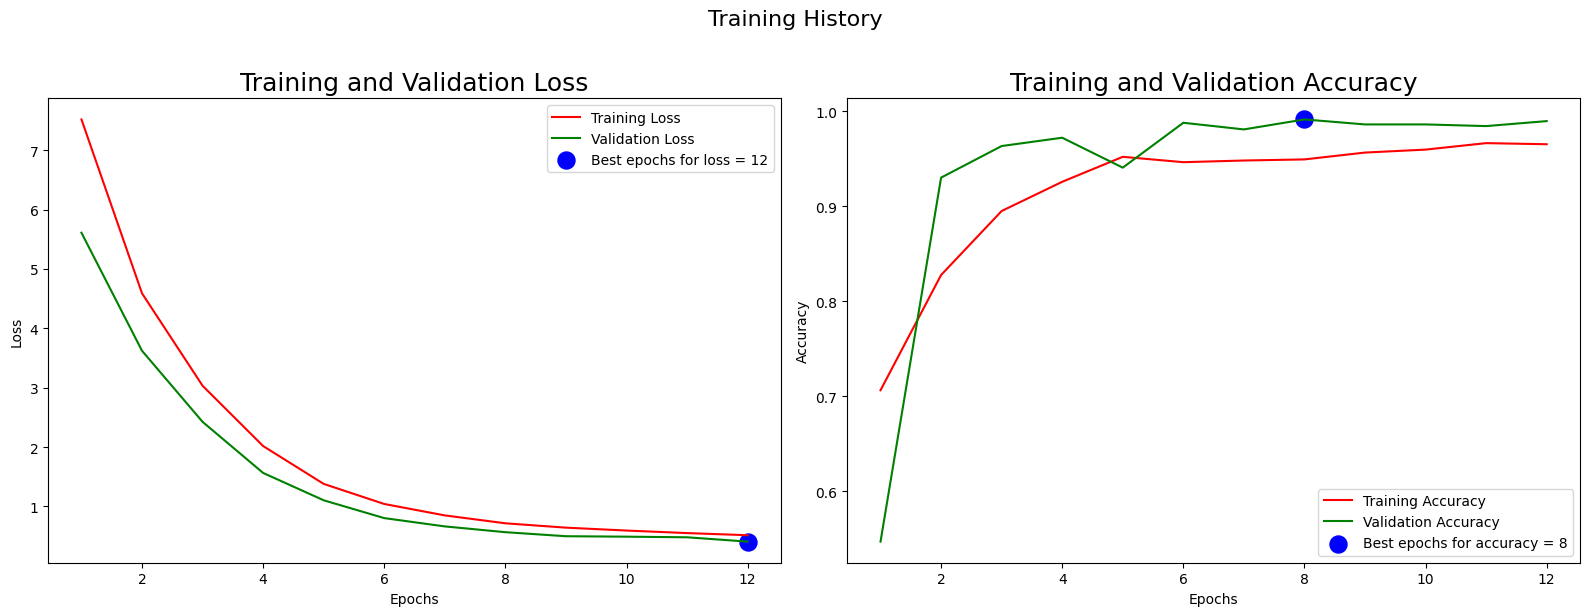

In [11]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(train_acc))]

loss_label = f'Best epochs for loss = {str(index_loss + 1)}'
acc_label = f'Best epochs for accuracy = {str(index_acc + 1)}'

data = {
    'Epoch': Epochs,
    'Training Loss': train_loss,
    'Validation Loss': val_loss,
    'Training Accuracy': train_acc,
    'Validation Accuracy': val_acc
}

df = pd.DataFrame(data)

csv_filename = 'densenet_training_history.csv'
df.to_csv(csv_filename, index=False)
print(f"Data saved to {csv_filename}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Training History', fontsize=16, y=1.02)

axes[0].plot(Epochs, train_loss, 'r', label='Training Loss')
axes[0].plot(Epochs, val_loss, 'g', label='Validation Loss')
axes[0].scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
axes[0].set_title('Training and Validation Loss', fontsize=18)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(Epochs, train_acc, 'r', label='Training Accuracy')
axes[1].plot(Epochs, val_acc, 'g', label='Validation Accuracy')
axes[1].scatter(index_acc + 1, val_highest, s=150, c='blue', label=acc_label)
axes[1].set_title('Training and Validation Accuracy', fontsize=18)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [12]:
sets_to_evaluate = [train_gen, valid_gen, test_gen]
set_names = ["Training", "Validation", "Test"]

steps = len(test_gen)

for set_name, data_gen in zip(set_names, sets_to_evaluate):
    score = model.evaluate(data_gen,
                         steps=len(data_gen),
                         verbose=1)
    loss, accuracy = score
    print(f"{set_name} Loss: {loss}")
    print(f"{set_name} Accuracy: {accuracy}")
    print('-' * 30)

322/322 ━━━━━━━━━━━━━━━━━━━━ 57s 177ms/step - accuracy: 0.9990 - loss: 0.3840
Training Loss: 0.38438910245895386
Training Accuracy: 0.9990272521972656
------------------------------
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.9901 - loss: 0.4059
Validation Loss: 0.4070694148540497
Validation Accuracy: 0.9895104765892029
------------------------------
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9982 - loss: 0.4044

2024-11-05 22:37:53.218457: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng42{k2=2,k4=2,k5=0,k6=0,k7=0} for conv (f32[15,24,150,150]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,24,150,150]{3,2,1,0}, f32[24,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=24, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-05 22:37:54.868317: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.651115206s
Trying algorithm eng42{k2=2,k4=2,k5=0,k6=0,k7=0} for conv (f32[15,24,150,150]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,24,150,150]{3,2,1,0}, f32[24,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=24, custom_ca

82/82 ━━━━━━━━━━━━━━━━━━━━ 25s 303ms/step - accuracy: 0.9982 - loss: 0.4040
Test Loss: 0.38411179184913635
Test Accuracy: 0.9969488978385925
------------------------------


In [13]:
preds = model.predict(test_gen, steps=len(test_gen))
y_pred = np.argmax(preds, axis=1)
print("Number of predictions:", len(y_pred))
print("Number of test samples:", len(test_gen.classes))

82/82 ━━━━━━━━━━━━━━━━━━━━ 26s 245ms/step
Number of predictions: 1311
Number of test samples: 1311


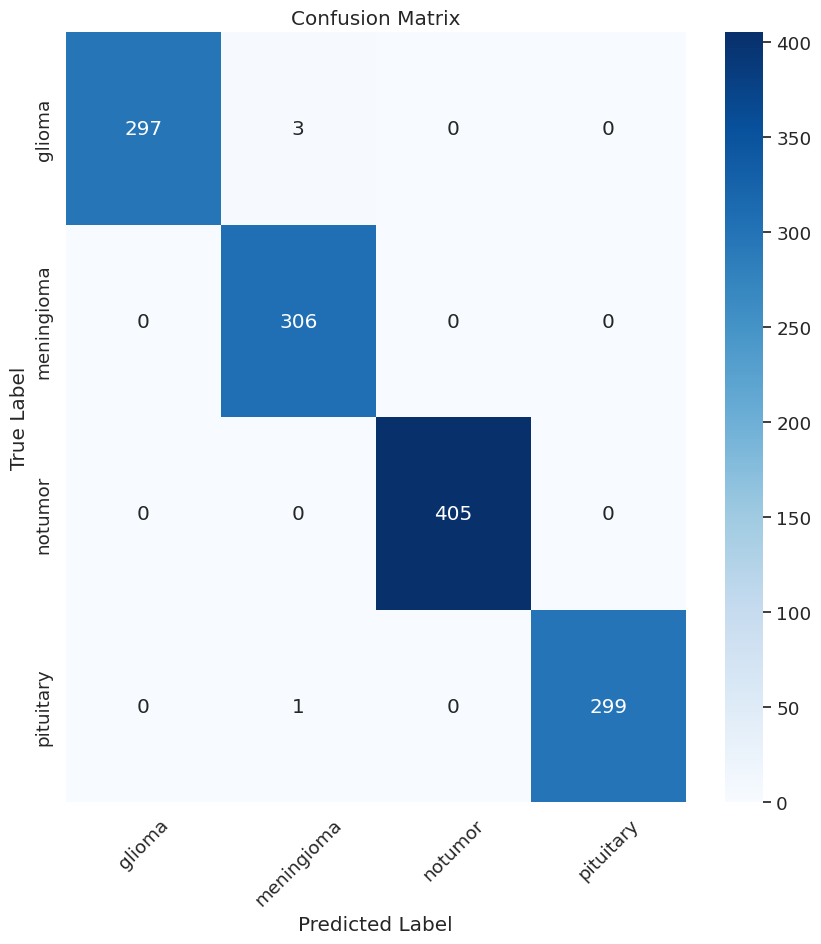

In [14]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.show()

In [15]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       300
  meningioma       0.99      1.00      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           1.00      1311
   macro avg       1.00      1.00      1.00      1311
weighted avg       1.00      1.00      1.00      1311

